In [115]:
from os import listdir
from os.path import isfile, join

mypath = "./fittings_1/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

import yaml


In [116]:
all_results = []
for folder in onlyfiles:
    if 'fit' in folder:
        with open(mypath+folder) as file:
            r = yaml.load(file, Loader=yaml.UnsafeLoader)
            r['days_ahead'] = int(folder.split("_")[1])
            r['mix_1'] = float(folder.split("_")[2])
            all_results.append(r)

In [117]:
r

{'days_ahead': 94,
 'iterations': 50,
 'mix_1': 0.3,
 'n_samples': 1,
 'result': [4.0, 1.0, 0.050405373905468724, 0.75, 0.1, 0.7500045494538725],
 'value': 19.820896167362648}

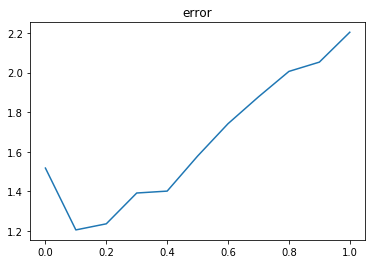

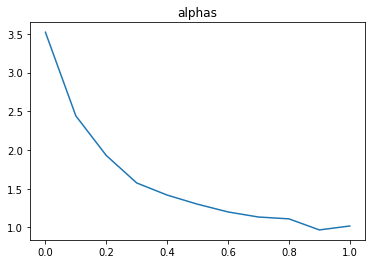

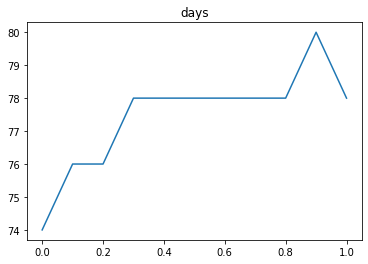

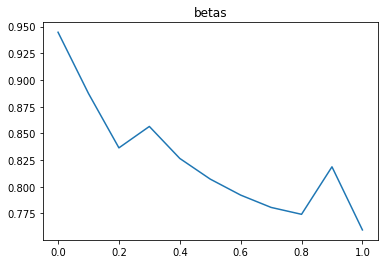

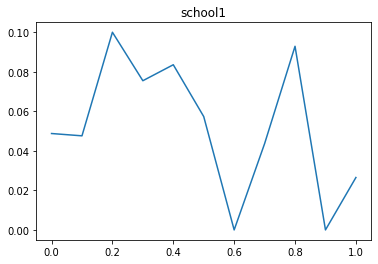

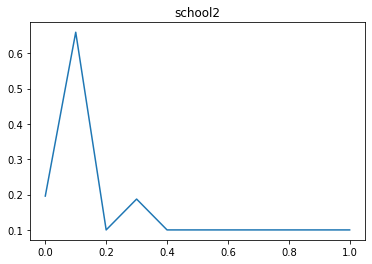

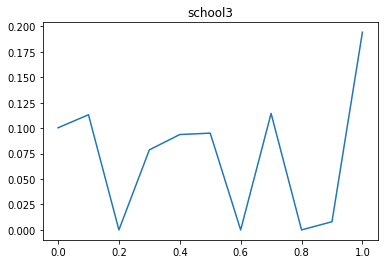

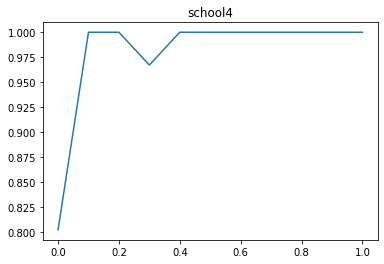

In [122]:
# Calculate best error
best = {round(a*0.1,2):{"value":float('inf')} for a in range(0,11)}
for r in all_results:
    mix_1 = r["mix_1"]
    days_ahead = r["days_ahead"]
    value = r["value"]
    if value<best[mix_1]['value']:
        best[mix_1] = {
            "value":value,
            "v":r["result"],
            "days_ahead":r["days_ahead"]
        }
        
vector_of_best = [best[round(a*0.1,2)]["value"] for a in range(0,11)]
vector_of_days = [best[round(a*0.1,2)]["days_ahead"] for a in range(0,11)]
vector_of_alphas = [best[round(a*0.1,2)]["v"][0] for a in range(0,11)]
vector_of_betas = [best[round(a*0.1,2)]["v"][1] for a in range(0,11)]
vector_of_school_1 = [best[round(a*0.1,2)]["v"][2] for a in range(0,11)]
vector_of_school_2 = [best[round(a*0.1,2)]["v"][3] for a in range(0,11)]
vector_of_school_3 = [best[round(a*0.1,2)]["v"][4] for a in range(0,11)]
vector_of_school_4 = [best[round(a*0.1,2)]["v"][5] for a in range(0,11)]


mix_1_values = [round(a*0.1,2) for a in range(0,11)]

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(mix_1_values, vector_of_best)
plt.title("error")
plt.show()

plt.figure(1)
plt.plot(mix_1_values, vector_of_alphas)
plt.title("alphas")
plt.show()

plt.figure(1)
plt.plot(mix_1_values, vector_of_days)
plt.title("days")
plt.show()

plt.figure(1)
plt.plot(mix_1_values, vector_of_betas)
plt.title("betas")
plt.show()

plt.figure(1)
plt.plot(mix_1_values, vector_of_school_1)
plt.title("school1")
plt.show()

plt.figure(1)
plt.plot(mix_1_values, vector_of_school_2)
plt.title("school2")
plt.show()

plt.figure(1)
plt.plot(mix_1_values, vector_of_school_3)
plt.title("school3")
plt.show()

plt.figure(1)
plt.plot(mix_1_values, vector_of_school_4)
plt.title("school4")
plt.show()

In [99]:
vector_of_best

[18.150203626773443,
 16.769239595850955,
 15.054230505217342,
 12.46747867573892,
 9.046266167873343,
 5.779439716902454,
 4.296929133875436,
 3.093152261008443,
 2.3145580495806803,
 1.7253242236482234,
 1.9060854184797058,
 2.19284041381898,
 2.4550454370642187,
 2.6763824794815294,
 2.866223053185003,
 3.0327616199096563,
 3.17943293025515,
 3.309744182252884,
 3.425952550025656,
 3.5304213209657207,
 3.626132970649155,
 3.723738679946666,
 3.834438529276306,
 3.911825330593119,
 3.989547925457063]

In [104]:
vector_of_best

[18.352482096995438,
 17.318966651108305,
 16.21267533516584,
 14.993214688770546,
 13.5648469778908,
 11.815246306636901,
 9.95660142084255,
 8.377367873194325,
 7.140529252588912,
 6.246423619808985,
 5.39547944401647,
 4.838613789265628,
 4.326671081249485,
 3.8622929315421546,
 3.4777272098437058,
 3.1815563819167862,
 2.998321869667776,
 2.887947829200935,
 2.750292776731675,
 2.6963555355138853,
 2.718265787043635,
 2.7470069917530844,
 2.768892411250007,
 2.795964279755394,
 2.8418947055997963]